# Using NIMA  as an Aesthetic Critic 

This notebook is divided into two sections:
- <a href="#section1">Section 1 - NIMA Pytorch</a> Reproduces the paper [NIMA: Neural Image Assessment](https://ieeexplore.ieee.org/document/8352823) which uses deep learning to aesthetically evaluate images as explained in this [blog post](https://ai.googleblog.com/2017/12/introducing-nima-neural-image-assessment.html). 

- <a href="#section2">Section 2 - Deploy Model as an Aesthetic Critic</a> Adapts and evaluates the model for use as an aesthetic critic to evaluate designs generated by genetic algorithms. 

## Section 1) NIMA Pytorch
<a name="section1"></a>

In [3]:
import torch
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
#%env CUDA_VISIBLE_DEVICES=""
#https://github.com/pytorch/pytorch/blob/master/torch/csrc/jit/OVERVIEW.md#jit-logging
%env PYTORCH_JIT_LOG_LEVEL=GRAPH_DEBUG
%env PYTORCH_JIT_TYPE_VERBOSITY=3 # the max
n_gpu = torch.cuda.device_count()
print("num gpu:",n_gpu )
import numpy as np
import scipy
from tqdm import tqdm
import sys
import os
import re
import inspect
from glob import glob
if torch.cuda.is_available():
  torch.cuda.empty_cache()
  device = torch.device('cuda') 
  print("found CUDA")
else:
  device = torch.device('cpu')
  
def softmax(x):
  return np.exp(x)/np.sum(np.exp(x))

env: PYTORCH_JIT_LOG_LEVEL=GRAPH_DEBUG
env: PYTORCH_JIT_TYPE_VERBOSITY=3 # the max
num gpu: 1
found CUDA


## Datasets

The primary dataset is [Aesthetic Visual Analysis](https://github.com/imfing/ava_downloader) (AVA)  which contains 255510 images with aesthetic ratings of photos scraped from the photo competition website [dpchallenge.com](https://www.dpchallenge.com/)

The paper used two other smaller datasets; Tampere Image Database 2013 (TID2013) and LIVE In the Wild Image Quality Challenge Database which will not be used. The paper itself found:

>We believe this observation shows that NIMA models trained on AVA can generalize to other test examples more effectively, whereas training on TID2013 results in poor performance on LIVE and AVA test sets.

The AVA dataset is not in the official collection of torch datasets so we must write our own data loader. Because we focus on aesthetics we have to be careful not to apply data augmentation that might reduce  the aesthetics, keeping only horizontal flip. We'll also crop landscape/portrait images to accommodate the model's preference for square images.

#### Labels

First we'll pre-process the labels. If you look ahead to the loss function, instead of labels of **one score** we want at a **histogram of scores**, which luckily, the data provides. Here is the first line from the file AVA.txt:

`-          -----score histogram----
DEX  IMGID  1 2 3 4  5  6  7  8 9 10  tag1 tag2 challenge
1    953619 0 1 5 17 38 36 15 6 5 1   1    22   1396
`

This image is rated above average with one person even scoring it a 10. We will not be using category tags but they can be found in the tags.txt file, in this case the tags are: Abstract,Macro and the  challenge was: 100_Meters



In [2]:
# DATASET Preprocess AVA Labels
DATA_PATH = "data/AVA_dataset/images/" 
all_files = []
  

lblraw = np.loadtxt("data/AVA_dataset/AVA.txt", dtype=int)
print("shape:",lblraw.shape," first line:",lblraw[0])
# make a hash by IMGID with a softmax of the scores
lblO = {}
for ii in range(lblraw.shape[0]):
  filename = str(lblraw[ii][1])+".jpg"
  lblO[filename] = softmax(lblraw[ii][2:12])
  all_files.append(filename)
  if ii==0:
    with np.printoptions(precision = 8, suppress = True):
      print("file:",filename," lbl:",lblO[filename])
      
# convert file list to full path
mm=0
id2del=[]
all_files_save=all_files.copy()
for ii in range(len(all_files)):
  if os.path.isfile(DATA_PATH +all_files[ii]):
    all_files[ii] = DATA_PATH +all_files[ii]
  elif(True): # remove it
    mm+=1
    id2del.append(ii)
    print("Missing file:",DATA_PATH+all_files[ii],mm)
all_files = np.array(all_files)
all_files = np.delete(all_files, np.array(id2del) )
print("num files:",all_files.shape)

shape: (255530, 15)  first line: [     1 953619      0      1      5     17     38     36     15      6
      5      1      1     22   1396]
file: 953619.jpg  lbl: [0.         0.         0.         0.         0.88079708 0.11920292
 0.         0.         0.         0.        ]


<a name='loader'></a>
## Torch Dataloader


In [63]:
# DATASET Image Loader 
# images are all 640x480 or 480x640 jpeg format
import torchvision.transforms as T
from PIL import Image

W_H = 224 # MobileNet wants >= 224 and < 480
BATCH_SIZE = 32
BATCH_SIZE_VAL = BATCH_SIZE * 3 # if low on RAM decrease this
NUM_EPOCHS = 4
LEARNING_RATE = 0.00001

nfiles = len(all_files)
print('There are %d total  images.' % nfiles," first one:",all_files[0])
train_size = int(0.8 * nfiles)
test_size = nfiles - train_size
if nfiles % BATCH_SIZE !=0:
  print("WARNING partial batch:",nfiles % BATCH_SIZE)

# DATASET CLASS
class ImageSet(Dataset):
    def __init__(self, imgA, size=None, lblO=lblO, device=None):
        self.size = size
        self.images = imgA
        self.lblO = lblO
        self.device = device
        self._length = len(self.images)
        # should work for: A batch of Tensor Images is a tensor of (B, C, H, W)
        self.transform = T.Compose([
                                T.RandomHorizontalFlip(.3),
                                T.Resize(W_H),
                                T.CenterCrop(W_H),
                                T.ToTensor(),# gets (C * H * W). scale 0–255 to 0–1.
                                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),#https://pytorch.org/hub/pytorch_vision_mobilenet_v2/
            
                                    ])

    def __len__(self):
        return self._length
    #https://pytorch.org/hub/pytorch_vision_mobilenet_v2/    color first, 0-1 float range
    def preprocess_image(self, image_path):
        #print("opening:",image_path)
        image = Image.open(image_path)
        if not image.mode == "RGB":
            image = image.convert("RGB")
        #image = np.array(image).astype(np.uint8)
        #image = (image / 255.0).astype(np.float32)
        #image = image.transpose(2, 1, 0)
        return image

    def __getitem__(self, i):
        img_path = self.images[i]
        img_dex  = re.sub(r'.*\/','',img_path)
        try:
            zimg = self.preprocess_image( img_path)
            image = self.transform( zimg )
        except:# this hack works when using shuffle!
            print(" X X X corrupt image:",img_path," SKIPPING ")
            img_path = self.goodpath
            img_dex  = re.sub(r'.*\/','',img_path)
            zimg = self.preprocess_image( img_path)
            image = self.transform( zimg )
         
        label = torch.tensor(lblO[img_dex])
        self.goodpath = img_path
        if self.device is not None:
          image = image.to(self.device)
          label = label.to(self.device)
        return image,label

#train_set = all_files[:10000]
full_dataset = ImageSet(all_files, size=nfiles, lblO=lblO, device=device)
train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False)

There are 13353 total  images.  first one: data/cfcolor_dataset/images/4684.jpg
WARNING partial batch: 9


label: tensor([5.3983e-06, 1.9859e-06, 2.1778e-03, 1.9859e-06, 1.1891e-01, 1.9859e-06,
        8.7861e-01, 1.9859e-06, 2.9474e-04, 1.9859e-06], device='cuda:0',
       dtype=torch.float64)


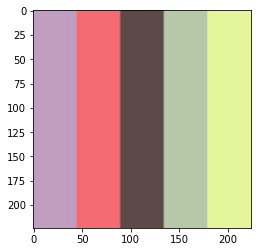

In [64]:
# test an image
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
inv_normalize = torchvision.transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def imshow(img):
    inv_tensor = inv_normalize(img)
    npimg = inv_tensor.detach().cpu().numpy()
    #print("min:",np.min(npimg),"max:",np.max(npimg))
    npimg = (((npimg)*255 )  ).astype(np.int32)
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)#
valid_iter = iter( valid_loader)
img,lbl = next( valid_iter  )
print("label:",lbl[2])
imshow(img[3])

## Model

The paper tested three pretrained image classification models with the final layer converted for score prediction. The models were: VGG16, Inception-v2, and MobileNet. It found Inception-v2 gave the slightly better results (accuracy of 81.51% vs 80.36%) but that MobileNet was twice as fast. We'll go with MobileNet as the huge speed gain trumps the slight accuracy deficit in production.

In [56]:
# GET PRETRAINED    = =  M O D E L  = =
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
print(model.classifier)
# instead of classifing images we want an aesthetic scale of 1 to 10
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=10)
print(model.classifier)
if False: # RECOVER from checkpoint
  print(" =============== RESTORE CHECKPOINT  ===============")
  checkpoint = torch.load("./models/model-NIMA-chk.pt")
  model.load_state_dict(checkpoint['model_state_dict'])
  #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
model.to(device)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)
 =============== RESTORE CHECKPOINT  ===============


Using cache found in /home/craig/.cache/torch/hub/pytorch_vision_v0.10.0


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Loss Function

One insight of the paper was to use an Earth Movers Distance(EMD) loss function to better approximate the complexities of images that have high standard deviations. For example, an image scoring low with a high standard deviation, is better than an image scoring low with a low deviation. The high deviation indicates it is a controversial image which some people like and some dislike.

Pytorch does not have this loss built-in (and recommends not using it for [point clouds](https://github.com/facebookresearch/pytorch3d/issues/211) ) so you need to implement your own, with a little help from the [internet](https://discuss.pytorch.org/t/implementation-of-squared-earth-movers-distance-loss-function-for-ordinal-scale/107927)


In [8]:
def earth_mover_distance(y_true, y_pred):
    return torch.sum(torch.mean(torch.square(torch.cumsum(y_true, dim=-1) - torch.cumsum(y_pred, dim=-1)), dim=-1))

## Training

The paper hints at using multiple rounds of 10 epochs, however as will be clear by the loss graph after training, 4 epochs is sufficient. For the first 2 epoch only the last classification layer is trained. Then all model layers are trained for 2 more epochs. The paper used stochastic gradient descent but we'll use Adam with a higher learning rate than the paper.

In [9]:
for param in model.parameters():
  param.requires_grad = False
for param in model.classifier.parameters():
  param.requires_grad = True
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
optim = torch.optim.Adam(model.parameters(),  lr=LEARNING_RATE)
decayRate = 0.9
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optim, gamma=decayRate)
#NUM_EPOCHS=7 # customize for additional training epochs
#LEARNING_RATE = 0.000005 # tweak lr, orig:0.00001

historyt=[]
historyv=[]
for epoch in range(NUM_EPOCHS):
    with tqdm(total=train_size) as pbar:
        nn=0
        for imgs,lbls in  train_loader:
            preds = model(imgs)
            loss = earth_mover_distance(lbls,preds)
            optim.zero_grad()
            loss.backward()
            optim.step()
            Loss=np.round(loss.cpu().detach().numpy().item(), 5)
            pbar.set_postfix(                Loss=Loss,                )
            pbar.update(BATCH_SIZE)
            pbar.refresh()
            if nn % 100 == 0 and nn>0:# validate
              model.eval()
              with torch.no_grad():
                  img,lbl = next( iter( valid_loader)  )
                  pred = model(img)
                  historyt.append(Loss)
                  loss = earth_mover_distance(lbl,pred)
                  Loss=np.round(loss.cpu().detach().numpy().item(), 5)
                  historyv.append(Loss)
                  print(f'validation loss: {Loss:.5f} ')
              model.train()
  
            nn +=  1
    my_lr_scheduler.step()
    if epoch ==1:
        print("==== STARTING TRAINING ON FULL MODEL=====")
        for param in model.parameters():
          param.requires_grad = True

## Results

The fist phase, just training the final layer reached a loss of 4.5, in the second phase, training the full model, loss reached: 2.5
The accuracy (below) matches the paper very well, right near 80%. Note that the paper only computed accuracy for binary classification; whether the picture was good or bad (score over 5 or below).

In [66]:
# first SAVE!
state_dict = model.state_dict()
torch.save(state_dict, "./models/model-NIMA-dict.pt")
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss,
            }, "./models/model-NIMA-chk.pt")

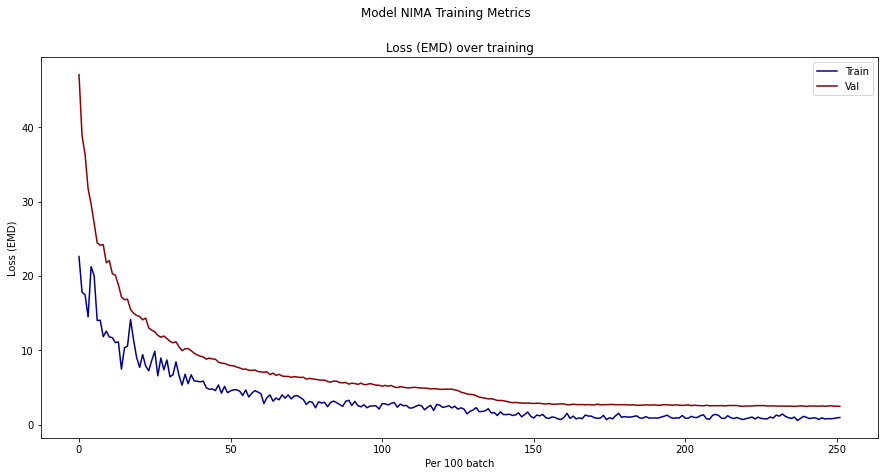

In [10]:
# plot training losses
fig,(ax1) = plt.subplots(1, 1, figsize=(15,7))
fig.suptitle(f'Model NIMA Training Metrics')
ax1.plot(historyt, color='darkblue', label="Train")
ax1.plot(historyv, color='darkred', label="Val")
ax1.set_title('Loss (EMD) over training')
ax1.set_xlabel('Per 100 batch')
ax1.set_ylabel('Loss (EMD)')
ax1.legend()
#plt.savefig(f'metrics_training')
plt.show()


In [ ]:
# TEST Model on Validation Dataset
# label images with: ground truth scores (t) and predicted scores(p) , green=match (score diff <.5), orange=difference < 1, red=difference > 1
torch.cuda.empty_cache()
zimg,zlbl = next( valid_iter  )
model.eval()
with torch.no_grad():
  prediction = model(zimg)
  prediction = prediction.cpu().detach().numpy()
  zlbl=zlbl.cpu().detach().numpy()
print("img shape:",zimg.shape," lbl shape:",zlbl.shape, " pred shape:",prediction.shape)
fig = plt.figure(figsize=(36, 24)) #Width, height in inches.
correct=0
gbcorrect=0
cats = [1,2,3,4,5,6,7,8,9,10]
catsf = np.array(cats)
for idx in np.arange(BATCH_SIZE_VAL):
    if False:# int scores
      mylbl = np.argmax(zlbl[idx])
      mypred = np.argmax(prediction[idx])
    else:    # float scores
      mylbl = np.sum(zlbl[idx]*catsf)
      mypred = np.sum(prediction[idx]*catsf)
    #print("lbl:",mylbl," pred:",mypred )
    if mylbl >= 5 and mypred >=5:
      gbcorrect +=1
    elif mylbl <5 and mypred <5:
      gbcorrect +=1
    if np.abs(mylbl-mypred)<0.5:
      correct+=1;
      mycolor = "green"
    elif  np.abs(mylbl-mypred)<1:
      mycolor = "orange"
    else: 
      mycolor = "red"
    ax = fig.add_subplot(8, BATCH_SIZE_VAL/8, idx+1, xticks=[], yticks=[]) #nrows, ncols, index
    ax.set_title("t{:.2f} p{:.2f}".format(mylbl,mypred), fontstyle='italic',color=mycolor)
    #ax.set_title(label, fontfamily='serif', loc='left', fontsize='medium')
    imshow(zimg[idx])
print("Exact Score Accuracy:",int(correct/BATCH_SIZE_VAL*100),"%")
print("Good/Bad Accuracy:",int(gbcorrect/BATCH_SIZE_VAL*100),"%")




<a name="section2"></a>
# Section 2) Deploy Model as an Aesthetic Critic


In this section the trained model is tested as a design critic using shapes from [Genolve](https://www.genolve.com), a website where you can make web graphics, banners, slide shows, music videos and more. A key feature of Genolve is that whenever you click a shape or design it uses simulated evolution to generate new variations of that shape.  Sometimes these variations look crufty and the idea is to use the NIMA model as an AI critic that will filter out the cruft and only show the good ones to the user.  It worked fairly well except for some edge cases *where the model prefers the cruft*. 

Here the top scoring designs are distorted (std=standard deviation and p=predicted score):
![Alt text](img/star_fail.png)![Alt text](img/horse_fail.png)

Another problem was liking pure whitespace (tip to photographers, use a lot of whitespace and you'll get a high rating):
![Alt text](img/NIMAwhitespace.png)

And sometimes a preference for the more boring design:
![Alt text](img/dino.png)

**To help remedy these deficiencies we train with more data.**


##  SAC Dataset
The [Simulacra Aesthetic Captions](https://github.com/JD-P/simulacra-aesthetic-captions) dataset contains images produced from Stable Diffusion runs where users rated the images produced.
To process the data we can re-use the same image loader used for AVA but the ratings require extra processsing:
- Extract from an SQL databasse
- Tabulate into a histogram
- Softmax the histogram


In [ ]:
#
# OPTIONAL Preprocess Labels for https://github.com/JD-P/simulacra-aesthetic-captions
#
import sqlite3
DATA_PATH = "data/sac_dataset/images/"
# Create a SQL connection to our SQLite database
con = sqlite3.connect("data/sac_dataset/sac_labels.sqlite")

sql_query = """SELECT name FROM sqlite_master
WHERE type='table';"""

# Creating cursor object using connection object
cursor = con.cursor()

# executing our sql query
cursor.execute(sql_query)
print("List of tables\n")

# printing all tables list
print(cursor.fetchall())

# The result of a "cursor.execute" can be iterated over by row
for row in cursor.execute('SELECT * FROM ratings LIMIT 15;'):
    print(row)
names = [description[0] for description in cursor.description]
print(names)
for row in cursor.execute('SELECT * FROM paths LIMIT 5;'):
    print(row)
names = [description[0] for description in cursor.description]
print(names)

sql_query = """SELECT * FROM ratings
INNER JOIN paths ON paths.iid = ratings.iid
WHERE ratings.rating IS NOT NULL  LIMIT 10;"""
for row in cursor.execute(sql_query):
    print(row)
    print("--score:",row[2]," -path:",row[5])
#PROCESS
lblO = {}
stemp = [0,0,0,0,0,0,0,0,0,0]
all_files = []
sql_query = """SELECT * FROM ratings
INNER JOIN paths ON paths.iid = ratings.iid
WHERE ratings.rating IS NOT NULL;"""
for row in cursor.execute(sql_query):
    key = row[5]
    if key in lblO:
      score = lblO[key].copy()
      score[row[2]-1]+=1
      print("already have:",key,"old score:",lblO[key]," and ",row[2]," -> ",score)
      lblO[key]=score
    else:
      score = stemp.copy()
      score[row[2]-1]=1
      all_files.append( key)
      lblO[key] = np.array(score)
con.close()
print("total labels:",len(lblO),"files:",len(all_files)," first one:",lblO[all_files[0]]," 2nd:",lblO[all_files[1]])
for ii in lblO:
  lblO[ii] = softmax(lblO[ii])
print("softmax first one:",lblO[all_files[0]]," 2nd:",lblO[all_files[1]])
for ii in range(len(all_files)):
  all_files[ii] = DATA_PATH +all_files[ii]
all_files = np.array(all_files)

Recreate the <a href="#loader">loader</a> with the new data and train.

## SAC Results
After training just 1 epoch using the same training loop from AVA at half the learning rate, the binary accuracy is up to 92%.
![SAC results](img/NIMAsac.png)

Most earlier deficiencies have resolved:
- The dinosaur kept its spots
- The horse silhouette is correct most of the time
- Blank white squares now score low

However, other concerns have surfaced; the model still likes the mangled star and has poor color taste; choosing a green rimmed heart:
![Mangled star](img/SACstar.png)
![Poor color sense](img/SACheart.png)

## Color Dataset
[Collaborative Filtering of Color Aesthetics](http://www.dgp.toronto.edu/~donovan/cfcolor/cfcolor.pdf) trys to train models to predict the color preferences of individual users. 

To get the dataset
13,343 color
themes were randomly sampled from the Adobe Kuler website. Each theme
was then rated on a scale of 1-5 stars by 40 participants on Amazon’s Mechanical Turk, producing a final dataset of 528,106
individual ratings. 

The ratings are in allMTurkRatings.mat (Mathimatica/Octave) variable testRatings of shape 528106x3 has columns: userid,dataid,rating

The data is inthemeData.mat variable datapoints->rgb  of shape 13343x15  has 13343 color swatches of 5 color patches in 3 rgb values.  This data was converted to image files in a separate process. 

In [57]:
# Color Data Swatches
import scipy.io
DATA_PATH = "data/cfcolor_dataset/images/"
themat = scipy.io.loadmat('data/cfcolor_dataset/release/themeData.mat')
print("theme keys:",themat.keys())
print("header",themat['__header__'])
#print("datapoints keys:",themat['datapoints'][0][0].keys())
rgbA=themat['datapoints']['rgb'][0][0]
dexA=themat['datapoints']['ids'][0][0]
print("rgb len:",rgbA.shape," first one:",rgbA[0])
print("dex len:",dexA.shape," first one:",dexA[0])

theme keys: dict_keys(['__header__', '__version__', '__globals__', 'datapoints'])
header b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Sun Feb 20 16:34:07 2011'
rgb len: (13343, 15)  first one: [0.34509804 0.54901961 0.54901961 0.28627451 0.41960784 0.45098039
 0.74901961 0.81960784 0.85098039 0.57647059 0.68235294 0.74901961
 0.45098039 0.21176471 0.25490196]
dex len: (13343, 1)  first one: [429863]


In [ ]:
# Color Rating Data
themat = scipy.io.loadmat('data/cfcolor_dataset/release/allMTurkRatings.mat')
print("theme keys:",themat.keys())
print("header",themat['__header__'])

lblraw = themat['testRatings']
print("shape:",lblraw.shape," first line:",lblraw[0])
# build up a histogram of the scores
lblO = {}
stemp = [0,0,0,0,0,0,0,0,0,0]
all_files = []
bestone=[0,0,0,0,0,0,0,0,0,0]
bestdex=[0,0,0,0,0,0,0,0,0,0]
for rr in range(lblraw.shape[0]):
    sdex = lblraw[rr][2]*2 - 2 # OPTION1 high std: convert 1-5 scale to 1-9, zero based 
    #sdex = lblraw[rr][2]+1     # OPTION2 low std: convert 1-5 shift 2-7, zero based
    key  = str(lblraw[rr][1])+".jpg"       # file id is hash key
    if key in lblO:
      score = lblO[key].copy()
      score[sdex]+=1
      print("already have:",key,"old score:",lblO[key]," and ",sdex," -> ",score)
      lblO[key]=score
      if score[sdex] > bestone[sdex]:# keep track of highest rated in each cat
        bestone[sdex] = score[sdex]
        bestdex[sdex] = key
    else:
      score = stemp.copy()
      score[sdex]=1
      all_files.append(key)
      lblO[key] = np.array(score)

print("total labels:",len(lblO),"files:",len(all_files)," first one:",lblO[all_files[0]]," 2nd:",lblO[all_files[1]])
for ii in lblO:
  lblO[ii] = softmax(lblO[ii])
print("softmax first one:",lblO[all_files[0]]," 2nd:",lblO[all_files[1]])
print("high votes by scores:",bestone," swatch:",bestdex)


### Add A Specific Training Nudge
Sometimes the generated SVG is corrupted and produces an error which gets captured as an image like this:
![Corrupted SVG](img/0.jpg)
We will add 10 copies of this image (0.jpg) into the color dataset with a low score so the model can recognize it and score it low and also add the complete white image (1.jpg) as well.

In [69]:
nextdex = len(all_files)
for ii in range(20):
  jj = int(ii/10)
  key = str(nextdex+ii)+".jpg"
  cmd = 'cp img/'+str(jj)+'.jpg '+DATA_PATH+key
  print("adding image:",cmd)
  os.system(cmd)
  all_files.append(key)
  lblO[key] = softmax( np.array([10,0,0,0,0,0,0,0,0,0]) )


adding image: cp img/0.jpg data/cfcolor_dataset/images/13353.jpg


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [61]:
#Convert to full datapath
mm=0
all_files_save=all_files.copy()
DATA_PATH = "data/cfcolor_dataset/images/" 
for ii in range(len(all_files)):
  if os.path.isfile(DATA_PATH +all_files[ii]):
    all_files[ii] = DATA_PATH +all_files[ii]
  else:
    mm+=1
    print("Missing file:",DATA_PATH+all_files[ii],mm)
all_files = np.array(all_files)

In [62]:
#high votes in each cat
for ii in range(10):
  if bestdex[ii] is not 0:
      image = Image.open(DATA_PATH+bestdex[ii])
      image.show()

Recreate the <a href="#loader">loader</a> with the new data and train for 7 epochs at half the AVA learning rate.

## Color Results
After training for 7 epochs, at half the AVA learning rate, the binary accuracy was 80% while the exact score accuracy was near 50%. This is likely because we chose the higher standard deviation method to convert the scale of 1-5 to a scale of 1-10.
![SAC results](img/NIMAcolor.png)

The poor color sense is now solved. Though color is very subjective, most people would agree that the color combinations of the heart are now ordered correctly from least attractive to most attractive:
![hearts](img/hearts.png)
Unfortunatly the star is proving a stubborn one to fix:
![stars](img/starfinal.png)

## Evolving the Perfect Design or Shape
With the model perfected the genetic algorithm can now run recursively: 
- Evolve a batch of 32 designs 
- The model selects the best one
- Repeat 

Here is the spirelli heart at 10 rounds of evolution with the model automatically selecting the best design for each round:
![10 rounds of evolution](img/heart10.png)

It got stuck from 4-7, a lot of designs were generated but the critic didn't think they were better, but a human may spot a better one such as this one:
![missed heart](img/heartsym.png)

10 rounds of evolution on a stacked trapezoid:
![10 rounds of evolution](img/purple.png)

And a similar case here, it got stuck after the 3rd round passing up several neat designs including this one:
![kite-like design](img/kite.png)

10 rounds of evolution on a landscape:
![landscape](img/hills.png)

And again choosing a rather plain landscape while alternatives like these were passed by: 
![landscape](img/hillsbetter.png)

## Conclusion
Though the AI critic falls short for unsupervised recursive design, it is still very useful for filtering cruft, spotting duplicates and providing aesthetic feedback to users. To try it out on [Genolve](https://www.genolve.com), just start up the design editor and while you're there ... maybe it is time to change your Twitter or LinkedIn cover photo :)